In [1]:
using Plots
using PyCall
using LaTeXStrings

# Get the absolute path to the parent directory containing models
parent_dir = dirname(pwd())  # This gives the parent directory path
pushfirst!(PyVector(pyimport("sys")."path"), parent_dir)

# Import the necessary Python modules
KDV = pyimport("models").KDV
plt = pyimport("matplotlib.pyplot")
nn = pyimport("torch.nn")

PyObject <module 'torch.nn' from '/home/karnav/anaconda3/lib/python3.11/site-packages/torch/nn/__init__.py'>

In [4]:
# Create and train the model
model = KDV(num_solitons=1, seed=1001)
losses = model.train()

/home/karnav/anaconda3/lib/python3.11/site-packages/torch/autograd/graph.py:825: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at /opt/conda/conda-bld/pytorch_1729647429097/work/aten/src/ATen/cuda/CublasHandlePool.cpp:135.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Dict{Any, Any} with 4 entries:
  "total"    => [0.142317, 0.0833492, 0.0425445, 0.0178562, 0.00668027, 0.00572…
  "pde"      => [0.0150934, 0.00844604, 0.00475412, 0.00273826, 0.00158301, 0.0…
  "initial"  => [0.609228, 0.359372, 0.185832, 0.083289, 0.0418075, 0.0465935, …
  "boundary" => [0.678105, 0.398105, 0.196826, 0.0706284, 0.0107481, 0.00281198…

In [10]:
# Extract each loss component
total_loss = losses["total"]
pde_loss = losses["pde"]
initial_loss = losses["initial"]
boundary_loss = losses["boundary"];

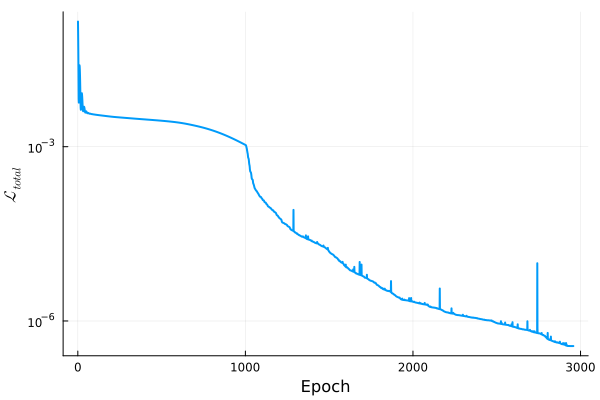

In [39]:
plot(total_loss, yscale=:log10, lw=2, legend=false)
xlabel!("Epoch")
ylabel!(L"$\mathcal{L}_{total}$")

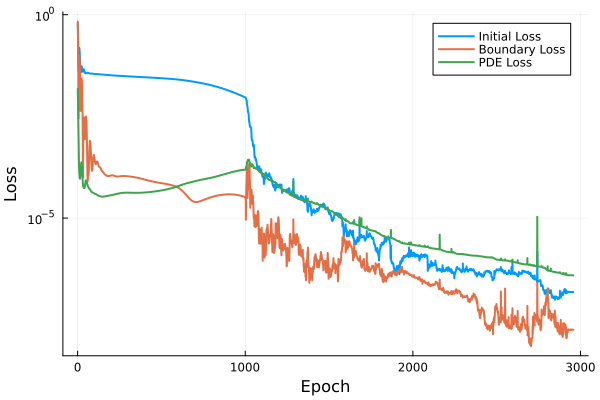

In [15]:
plot(initial_loss, yscale=:log10, lw=2, label="Initial Loss")
plot!(boundary_loss, yscale=:log10, lw=2, label="Boundary Loss")
plot!(pde_loss, yscale=:log10, lw=2, label="PDE Loss")
xlabel!("Epoch")
ylabel!("Loss")

In [22]:
include("plotting.jl")

plot_losses (generic function with 2 methods)

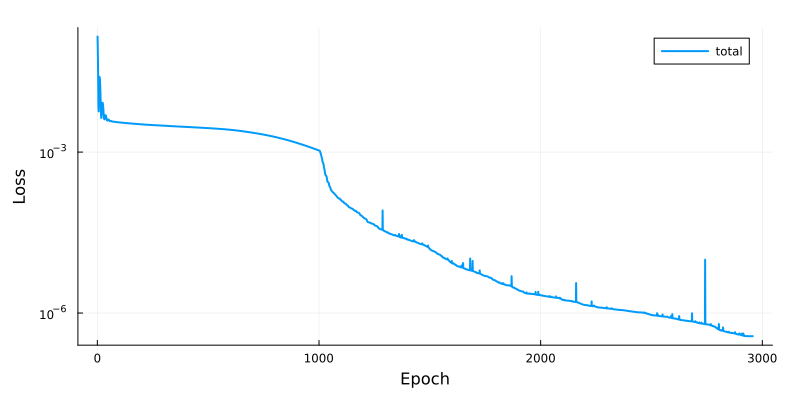

In [27]:
# plot_losses(losses, ("initial", "boundary", "pde"))
plot_losses(losses, ("total",))

### Plotting Average Loss

Now we want to train the model many many times and plot the loss 

In [28]:
num_runs = 10
total_losses = []

for i in 1:num_runs
    model = KDV(num_solitons=1)
    losses = model.train()
    push!(total_losses, losses["total"])
end

Using device: cuda

                Training domain setup complete: 
                - 30000 collocation points
                - 30000 initial points
                - 30000 boundary points
Using 1-soliton initial condition.
Starting Adam optimization...
Adam - Epoch 0/1000, Total Loss: 1.423173e-01
Adam - Epoch 100/1000, Total Loss: 3.565718e-03
Adam - Epoch 200/1000, Total Loss: 3.282509e-03
Adam - Epoch 300/1000, Total Loss: 3.100787e-03
Adam - Epoch 400/1000, Total Loss: 2.943638e-03
Adam - Epoch 500/1000, Total Loss: 2.792988e-03
Adam - Epoch 600/1000, Total Loss: 2.599833e-03
Adam - Epoch 700/1000, Total Loss: 2.293656e-03
Adam - Epoch 800/1000, Total Loss: 1.915891e-03
Adam - Epoch 900/1000, Total Loss: 1.480898e-03
Adam - Epoch 999/1000, Total Loss: 1.071276e-03

Starting L-BFGS optimization...
L-BFGS - Iteration 100, Total Loss: 1.273333e-04
L-BFGS - Iteration 200, Total Loss: 6.080010e-05
L-BFGS - Iteration 300, Total Loss: 3.308356e-05
L-BFGS - Iteration 400, Total Loss: 2.

InterruptException: InterruptException:

In [ ]:
# take average of total losses
avg_losses = sum(total_losses, ) / num_runs

# plot average loss with a shaded region of the standard deviation


In [16]:
using Plots
using Statistics
using LaTeXStrings
using Plots.PlotMeasures

function train_multiple_runs(num_runs::Int, model_params=Dict())
    # Initialize an array to store all losses from each run
    all_losses = []
    
    for i in 1:num_runs
        # Create and train a model
        if haskey(model_params, :seed)
            # If seed is provided, increment it for each run to get variation
            model = KDV(num_solitons=1, seed=model_params[:seed] + i - 1)
        else
            model = KDV(num_solitons=1)
        end
        
        # Train the model and collect losses
        losses = model.train()
        push!(all_losses, losses["total"])
    end
    
    return all_losses
end

function plot_loss_statistics(all_losses; log_scale=true)
    # Find the length of each loss array
    loss_lengths = [length(losses) for losses in all_losses]
    
    # Get the minimum length to ensure all arrays have same dimension
    min_length = minimum(loss_lengths)
    
    # Truncate all loss arrays to the minimum length
    truncated_losses = [losses[1:min_length] for losses in all_losses]
    
    # Convert to a matrix where each column is a run
    loss_matrix = hcat(truncated_losses...)
    
    # Calculate statistics
    mean_loss = mean(loss_matrix, dims=2)[:, 1]  # Mean across runs for each epoch
    std_loss = std(loss_matrix, dims=2)[:, 1]    # Standard deviation across runs
    
    # Create x-axis values (epochs)
    epochs = 1:min_length
    
    # Set plot options based on scale
    if log_scale
        yscale = :log10
        # Force positive values for log scale
        mean_loss = max.(mean_loss, 1e-10)
        std_loss = max.(std_loss, 1e-10)
    else
        yscale = :identity
    end
    
    # Create the plot with explicit tick settings
    p = plot(
        size=(800, 500),
        margin=5mm,
        legend=:topright,
        xlabel="Epoch",
        ylabel="Loss",
        yscale=yscale,
        yticks=:auto  # Let Plots determine appropriate ticks
    )
    
    # Add standard deviation as a shaded area using fillrange
    upper_bound = mean_loss .+ std_loss
    lower_bound = max.(mean_loss .- std_loss, 1e-10)  # Prevent negative values in log scale
    
    # Plot the shaded area for standard deviation
    plot!(p, epochs, upper_bound, fillrange=lower_bound, 
          fillalpha=0.3, label="±1σ", color=:blue, linewidth=0)
    
    # Plot the mean line on top
    plot!(p, epochs, mean_loss, color=:blue, linewidth=2, label=false)
    return p
end

plot_loss_statistics (generic function with 1 method)

In [18]:
# Run the training multiple times
num_runs = 20
all_losses = train_multiple_runs(num_runs)

Adam - Epoch 200/1000, Total Loss: 3.149660e-03
Adam - Epoch 300/1000, Total Loss: 2.974698e-03
Adam - Epoch 400/1000, Total Loss: 2.826533e-03
Adam - Epoch 500/1000, Total Loss: 2.688013e-03
Adam - Epoch 600/1000, Total Loss: 2.525588e-03
Adam - Epoch 700/1000, Total Loss: 2.335249e-03
Adam - Epoch 800/1000, Total Loss: 2.111969e-03
Adam - Epoch 900/1000, Total Loss: 1.921586e-03
Adam - Epoch 999/1000, Total Loss: 1.754104e-03

Starting L-BFGS optimization...
L-BFGS - Iteration 100, Total Loss: 3.956280e-04
L-BFGS - Iteration 200, Total Loss: 2.187654e-04
L-BFGS - Iteration 300, Total Loss: 1.668390e-04
L-BFGS - Iteration 400, Total Loss: 1.346779e-04
L-BFGS - Iteration 500, Total Loss: 1.111010e-04
L-BFGS - Iteration 600, Total Loss: 8.983940e-05
L-BFGS - Iteration 700, Total Loss: 6.582688e-05
L-BFGS - Iteration 800, Total Loss: 4.783246e-05
L-BFGS - Iteration 900, Total Loss: 3.512763e-05
L-BFGS - Iteration 1000, Total Loss: 2.542703e-05
L-BFGS - Iteration 1100, Total Loss: 1.82214

20-element Vector{Any}:
 [0.029945291578769684, 0.019223378971219063, 0.017900705337524414, 0.014044057577848434, 0.010079927742481232, 0.008492645807564259, 0.008779219351708889, 0.008892292156815529, 0.007989788427948952, 0.006779075600206852  …  1.1633476333372528e-6, 1.1632845371423173e-6, 1.163278966487269e-6, 1.1632816949713742e-6, 1.1632791938609444e-6, 1.16330386390473e-6, 1.1632906762315542e-6, 1.1632914720394183e-6, 1.1632802170424839e-6, 1.163278966487269e-6]
 [0.00661481311544776, 0.0070412298664450645, 0.0054328483529388905, 0.0046461038291454315, 0.005096711218357086, 0.004971577785909176, 0.004372575785964727, 0.004160240758210421, 0.004364728461951017, 0.004369925241917372  …  2.1431340258004639e-7, 2.1431296204355021e-7, 2.1431424102047458e-7, 2.1430793140098103e-7, 2.143005133348197e-7, 2.1429356422686396e-7, 2.1430636820696236e-7, 2.1429485741464305e-7, 2.1430049912396498e-7, 2.1429356422686396e-7]
 [0.03066857159137726, 0.008689509704709053, 0.009640433825552464, 0.

In [12]:
function plot_loss_statistics(all_losses; log_scale=true)
    # Process data as before
    loss_lengths = [length(losses) for losses in all_losses]
    min_length = minimum(loss_lengths)
    truncated_losses = [losses[1:min_length] for losses in all_losses]
    loss_matrix = hcat(truncated_losses...)
    
    # Calculate statistics
    mean_loss = mean(loss_matrix, dims=2)[:, 1]
    std_loss = std(loss_matrix, dims=2)[:, 1]
    epochs = 1:min_length
    
    # Create the plot
    p = plot(
        size=(800, 500),
        margin=5mm,
        legend=:topright,
        xlabel="Epoch",
        ylabel="Loss",
        yticks=:auto
    )
    
    if log_scale
        # For log scale, we need to use multiplicative factors for symmetric appearance
        upper_bound = mean_loss .* exp.(std_loss ./ mean_loss)
        lower_bound = mean_loss ./ exp.(std_loss ./ mean_loss)
        
        # Plot with custom ribbon bounds and log scale
        plot!(p, epochs, mean_loss, 
              ribbon=(mean_loss - lower_bound, upper_bound - mean_loss),
              fillalpha=0.3, label="±1σ", color=:blue, linewidth=2,
              yscale=:log10)
    else
        # For linear scale, standard additive approach works fine
        plot!(p, epochs, mean_loss, 
              ribbon=std_loss,
              fillalpha=0.3, label="±1σ", color=:blue, linewidth=2)
    end
    
    return p
end

plot_loss_statistics (generic function with 1 method)

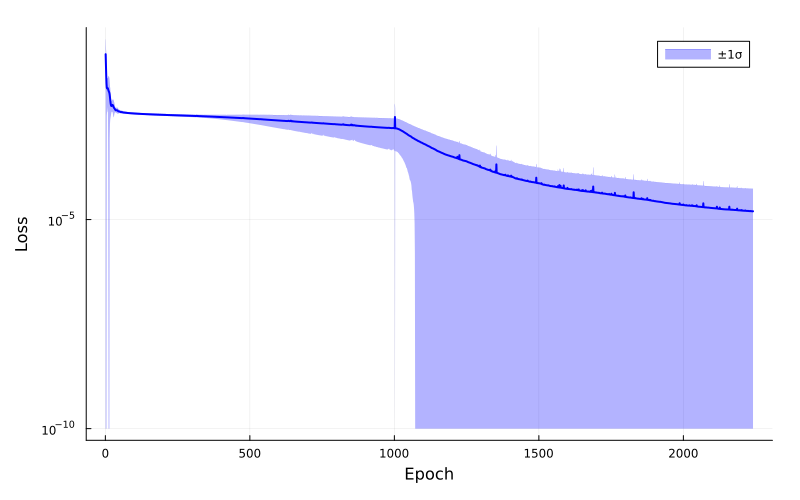

In [17]:
# Plot the results
plot_loss_statistics(all_losses, log_scale=true)